In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pandas as pd
import nltk

"""
from google.colab import drive
drive.mount('/content/drive')
"""

# Carregar o DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab/TextClassifier/dataset/uol-noticias.csv', sep=';', encoding='ISO-8859-1')

In [ ]:
# Análise exploratória inicial
print('Shape: ', df.shape)
print('Columns: ', df.columns)
print('\nValores Nulos:')
print(df.isnull().sum())

# Index com valores nulos
index_with_nan = df.index[df.isnull().any(axis=1)]
print(f'\nIndex com valores nulos: {index_with_nan.shape}\n')

# Remoção de linhas com valores nulos
df.drop(index_with_nan, inplace=True)
df.reset_index()

# Adicionar coluna de ID_CATEGORIA
df['ID_CATEGORIA'] = df['CATEGORIA'].factorize()[0]
category_id_df = df[['CATEGORIA', 'ID_CATEGORIA']].drop_duplicates().sort_values('ID_CATEGORIA')
id_to_category = dict(category_id_df[['ID_CATEGORIA', 'CATEGORIA']].values)

# Correspondência "ID_CATEGORIA" e "CATEGORIA"
for item in id_to_category.items():
    print(f'ID: {item[0]},  CATEGORIA: {item[1]}')

# Amostra da estrutura do df
print()
df.head(5)

Shape:  (504767, 3)
Columns:  Index(['CATEGORIA', 'TEXTO', 'ID_CATEGORIA'], dtype='object')

Valores Nulos:
CATEGORIA       0
TEXTO           0
ID_CATEGORIA    0
dtype: int64

Index com valores nulos: (0,)

ID: 0,  CATEGORIA: coronavirus
ID: 1,  CATEGORIA: politica
ID: 2,  CATEGORIA: esporte
ID: 3,  CATEGORIA: carro
ID: 4,  CATEGORIA: educacao
ID: 5,  CATEGORIA: entretenimento
ID: 6,  CATEGORIA: economia
ID: 7,  CATEGORIA: saude



,CATEGORIA,TEXTO,ID_CATEGORIA
0,coronavirus,"Na manhã de ontem, o chefe do Executivo recebe...",0
1,coronavirus,Os parentes acreditaram que os dois pudessem e...,0
2,politica,28.jan.2020 - Equipe médica embarca rumo a Wuh...,1
3,esporte,A estratégia serve para o Alviverde melhorar a...,2
4,coronavirus,31.jan.2020 - Tripulação embarca em voo com má...,0


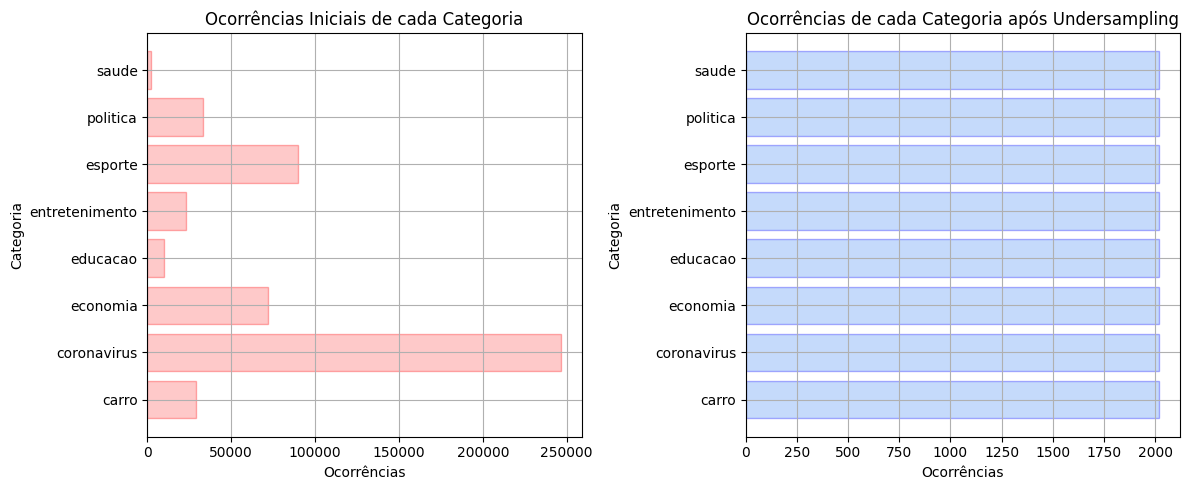

In [ ]:
# Visualização de Ocorrências de Categorias
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Ocorrências Iniciais
freqs = df['CATEGORIA'].value_counts().sort_index()
axs[0].barh(freqs.index, freqs, alpha=0.3, color='#fc4c4f', edgecolor='red')
axs[0].set_title('Ocorrências Iniciais de cada Categoria')
axs[0].set_xlabel('Ocorrências')
axs[0].set_ylabel('Categoria')
axs[0].grid(True)

# Undersampling
categorias = df['ID_CATEGORIA'].unique()
min_samples = df['CATEGORIA'].value_counts().min()
df_filtered = df.groupby('ID_CATEGORIA').apply(lambda x: x.sample(min_samples)).reset_index(drop=True)

# Após Undersampling
counts_by_category = df_filtered.groupby('CATEGORIA').TEXTO.count().sort_values(ascending=True)

axs[1].barh(counts_by_category.index, counts_by_category, alpha=0.3, color='#4287f5', edgecolor='blue')
axs[1].set_title('Ocorrências de cada Categoria após Undersampling')
axs[1].set_xlabel('Ocorrências')
axs[1].set_ylabel('Categoria')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Texto no SKLearn
nltk.download('stopwords')
tfidf = TfidfVectorizer(min_df=5, encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords.words('portuguese'))

features = tfidf.fit_transform(df_filtered.TEXTO.values.astype('U')).toarray()
labels = df_filtered.ID_CATEGORIA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Criação de Classificador
X_train, X_test, y_train, y_test = train_test_split(df_filtered['TEXTO'], df_filtered['CATEGORIA'], test_size=0.2, random_state=0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.values.astype('U'))
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
# Frases para teste
test_phrases = [
    'Os estudantes de engenharia demoram o dobro do tempo na faculdade.',
    'O vírus comeu o soldo.',
    'Jogar League of Legends dá raiva.',
    'Eu gosto de carros',
]

# Teste do classificador e impressão dos resultados
for text in test_phrases:
    prediction = clf.predict(count_vect.transform([text]))[0]
    print(f"Texto: {text}\nPredição: {prediction}\n")


Texto: Os estudantes de engenharia demoram o dobro do tempo na faculdade.
Predição: educacao

Texto: O vírus comeu o soldo.
Predição: saude

Texto: Jogar League of Legends dá raiva.
Predição: esporte

Texto: Eu gosto de carros
Predição: carro



In [ ]:
# Seleção do Modelo
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# Geração dos modelos:
CV = 5  # Uso de validação cruzada com 5 folds:
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

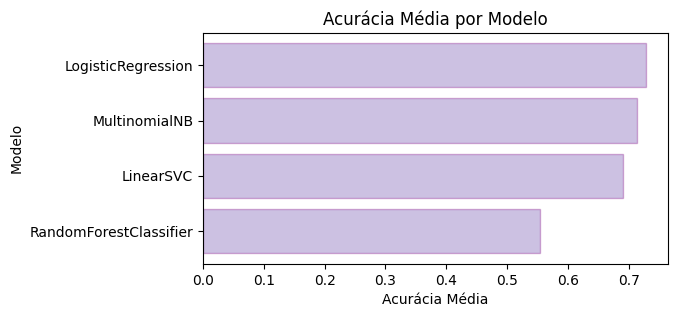

In [ ]:
# Calcular a acurácia média por modelo
acuracia_media = cv_df.groupby('model_name')['accuracy'].mean()

# Converter a Série em DataFrame
df_acuracia_media = pd.DataFrame(acuracia_media).reset_index()

# Ordenar o DataFrame pela coluna 'accuracy'
df_acuracia_media = df_acuracia_media.sort_values(by='accuracy', ascending=True)

# Criar o gráfico de barras horizontais
plt.figure(figsize=(6, 3))
plt.barh(df_acuracia_media['model_name'], df_acuracia_media['accuracy'], alpha=0.3, color='#5933a1', edgecolor='purple')
plt.xlabel('Acurácia Média')
plt.ylabel('Modelo')
plt.title('Acurácia Média por Modelo')

plt.show()